# Welcome to Torch study week 2

multi-head scaled-dot attention을 RNN-encoder seq2seq에 적용해보기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.fr'), 
                                                    fields = (SRC, TRG),
                                                   root = '/home/long8v/torch_study/paper/03_attention/.data')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
examples = ['i drink beer', 'i am drunk', 'i am good', 'you good? i am good'] 
preprocessed = [SRC.preprocess(example) for example in examples]
processed = SRC.process(preprocessed)
preprocessed, processed

([['i', 'drink', 'beer'],
  ['i', 'am', 'drunk'],
  ['i', 'am', 'good'],
  ['you', 'good', '?', 'i', 'am', 'good']],
 tensor([[   2,  956,  413,  460,    3,    1,    1,    1],
         [   2,  956, 2647, 3995,    3,    1,    1,    1],
         [   2,  956, 2647, 1192,    3,    1,    1,    1],
         [   2, 1145, 1192, 2417,  956, 2647, 1192,    3]]))

In [11]:
trg_ = ['나 맥주 마신다', '나는 취했다', '나 괜찮다', '너 괜찮냐? 난 괜찮다'] 
trg_preprocessed = [TRG.preprocess(example) for example in examples]
trg_processed = TRG.process(trg_preprocessed)
trg_preprocessed, trg_processed

([['i', 'drink', 'beer'],
  ['i', 'am', 'drunk'],
  ['i', 'am', 'good'],
  ['you', 'good', '?', 'i', 'am', 'good']],
 tensor([[   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2,    0,    0, 2054, 5622,    0,    0,    3]]))

In [12]:
x = processed

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = False, batch_first = True)
        
        self.fc = nn.Linear(enc_hid_dim, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(hidden[-1,:,:]))
        # |hideen| = (batch_size, hid_dim * 2) 
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [14]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 620 # the word embedding dimensionality
DEC_EMB_DIM = 620 # the word embedding dimensionality
ENC_HID_DIM = 1000 # the size of a hidden layer n 
DEC_HID_DIM = 1000 # the size of a hidden layer n 
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5 
MAXOUT_HID_DIM = 500 # the size of the maxout hidden layer in the deep output l
MAXOUT_POOLSIZE = 2

# attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)


In [15]:
outputs, hidden = enc(processed)
outputs.shape
# batch_size, encoder_source_len, encoder_hidden_size

torch.Size([4, 8, 1000])

In [16]:
processed.shape

torch.Size([4, 8])

In [17]:
hidden.shape

torch.Size([4, 1000])

In [18]:
key = value = outputs

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        query = query.to(device)
        key = key.to(device)
        value = value.to(device)
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        # k.permute(0, 1, 3, 2) = [batch size, n heads, head dim, key len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        # n_heads * head_dim을 hid dim으로 합치는 부분
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [20]:
att = MultiHeadAttentionLayer(ENC_HID_DIM, 4, 0.5, device)

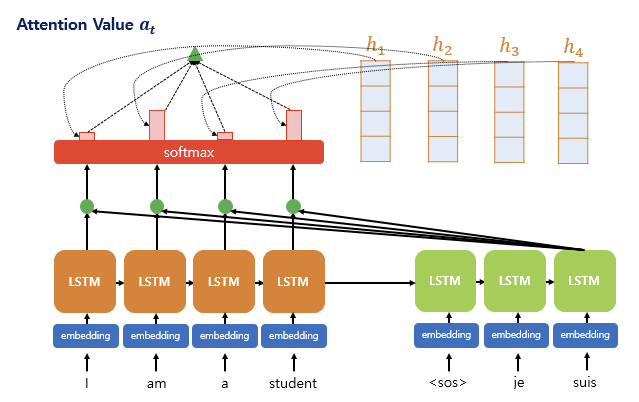

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        
        # attention class를 input으로 받음
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, dec_hid_dim, batch_first = True)

        self.fc_out = nn.Linear(dec_hid_dim + enc_hid_dim, output_dim)
        # trg_hid_dim(디코더의 hidden dimension) + enc_hid_dim(곱해지는 value 벡터의 크기(=enc_hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # decoder의 forward는 지난달 seq2seq처럼 한 토큰임에 주의!
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(1)
        
        #input = [batch size, 1]
        embedded = self.dropout(self.embedding(input))
        #embedded = [batch size, 1, emb dim]
        
        
        # query : hidden state, key : encoder_outputs, value : encoder_outputs
        x, _ = self.attention(hidden, encoder_outputs, encoder_outputs)
        # | x | = src_max_len, batch_size, hid_dim
#         print(f'hidden shape : {hidden.shape}')
#         print(f'embedded_shape : {embedded.shape} hidden_shape : {hidden.unsqueeze(0).shape}')
        output, hidden = self.rnn(embedded, hidden.unsqueeze(0)) # batch first여도 hidden은 seqlen이 먼저 나옴
#         print(f'hidden shape : {hidden.shape}')
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
#         assert (output == hidden).all()
        
        # output 예측할 때 
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        
        # | output | = (batch_size, dec_hid_dim) |attention shape| = (batch_size, query_len, hid_dim) 
#         print(f'x shape {x.shape} output shape {output.shape}')
        # batch size, seq_len, enc_hid_dim + dec_chid_dim
        prediction = torch.cat((x, output), dim = 2)
        
        prediction = prediction.squeeze(1)
        # | prediction | = (batch_size, enc_hid_dim + dec_hid_dim)
        prediction = self.fc_out(prediction)
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [22]:
trg_processed[:, 0]

tensor([2, 2, 2, 2])

In [23]:
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, att)

In [24]:
trg_processed.device

device(type='cpu')

In [25]:
dec.to(device)

Decoder(
  (attention): MultiHeadAttentionLayer(
    (fc_q): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_k): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_v): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_o): Linear(in_features=1000, out_features=1000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (embedding): Embedding(6469, 620)
  (rnn): GRU(620, 1000, batch_first=True)
  (fc_out): Linear(in_features=2000, out_features=6469, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [26]:
key.shape, value.shape

(torch.Size([4, 8, 1000]), torch.Size([4, 8, 1000]))

In [27]:
key.shape, value.shape

(torch.Size([4, 8, 1000]), torch.Size([4, 8, 1000]))

In [28]:
trg_processed[0]

tensor([   2, 5622,    0,    0,    3,    1,    1,    1])

In [29]:
hidden.shape

torch.Size([4, 1000])

In [30]:
hidden.shape

torch.Size([4, 1000])

In [31]:
dec(trg_processed[:, 0].to(device), hidden.to(device), key)

(tensor([[ 0.0209, -0.1112,  0.1211,  ..., -0.0264, -0.1546, -0.0713],
         [-0.0343, -0.0509,  0.1533,  ..., -0.0275, -0.1151,  0.0111],
         [ 0.0660,  0.0077,  0.0497,  ...,  0.0703, -0.2147,  0.0310],
         [ 0.0765, -0.0707, -0.0359,  ..., -0.0085, -0.2116, -0.0658]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[-0.1411,  0.0454, -0.0050,  ..., -0.1320, -0.1867,  0.3022],
         [-0.1974, -0.0929,  0.3559,  ..., -0.0712,  0.1256,  0.1987],
         [-0.3234,  0.1873,  0.5970,  ..., -0.0764, -0.1942,  0.0581],
         [-0.0325, -0.2183,  0.5597,  ..., -0.0624, -0.4133,  0.5072]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [32]:
dec

Decoder(
  (attention): MultiHeadAttentionLayer(
    (fc_q): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_k): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_v): Linear(in_features=1000, out_features=1000, bias=True)
    (fc_o): Linear(in_features=1000, out_features=1000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (embedding): Embedding(6469, 620)
  (rnn): GRU(620, 1000, batch_first=True)
  (fc_out): Linear(in_features=2000, out_features=6469, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [33]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0] # 수정
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[:, t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[:, t] if teacher_force else top1 # 수정

        return outputs

In [34]:
model = Seq2Seq(enc, dec, device).to(device)

In [35]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'rnn.weight' in name:
            # recurrent weight matrix 
            # orthogonal should have dim 2 or more
            nn.init.orthogonal_(param.data)
        elif 'attention.v' in name:
            nn.init.zeros_(param.data)
        elif 'attention' in name:
            nn.init.normal_(param.data, 0, 0.001 ** 2)
        elif 'weight' in name:
            nn.init.normal_(param.data, 0, 0.01 ** 2)
        else:
            nn.init.constant_(param.data, 0)
            

### main에 넣기

In [36]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5893, 620)
    (rnn): GRU(620, 1000, batch_first=True)
    (fc): Linear(in_features=1000, out_features=1000, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): MultiHeadAttentionLayer(
      (fc_q): Linear(in_features=1000, out_features=1000, bias=True)
      (fc_k): Linear(in_features=1000, out_features=1000, bias=True)
      (fc_v): Linear(in_features=1000, out_features=1000, bias=True)
      (fc_o): Linear(in_features=1000, out_features=1000, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (embedding): Embedding(6469, 620)
    (rnn): GRU(620, 1000, batch_first=True)
    (fc_out): Linear(in_features=2000, out_features=6469, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,345,909 trainable parameters


maxout 미적용 시, The model has 21,196,869 trainable parameters<Br>
maxout 적용 시, The model has 14,631,921 trainable parameters<Br>
maxout 적용 및 논문 파라미터 적용 시, The model has 40,127,409 trainable parameters

In [38]:
optimizer = optim.Adam(model.parameters())

In [39]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# bleu score
https://cloud.google.com/translate/automl/docs/evaluate

refs : 정답<br>
sys : 후보

In [40]:
from sacrebleu import corpus_bleu, sentence_bleu

In [41]:
for batch in train_iterator:
    src = batch.src
    trg = batch.trg
    break

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [42]:
src.shape, trg.shape

(torch.Size([16, 23]), torch.Size([16, 23]))

In [43]:
output = model(src, trg)

In [44]:
output = model(src, trg)

In [45]:
output.shape # seq_len, batch_size, trg_token_list

torch.Size([16, 23, 6469])

In [46]:
TRG_PAD_IDX

1

In [47]:
output.argmax(-1).shape

torch.Size([16, 23])

In [48]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
TRG_special_tokens = [TRG_EOS_IDX, TRG_PAD_IDX, TRG_UNK_IDX]

In [49]:
def get_speical_token(field):
    def get_stoi(idx):
        return field.vocab.stoi[idx]
    return [get_stoi(field.pad_token), get_stoi(field.unk_token), 
            get_stoi(field.eos_token)]

In [50]:
def get_itos_str(tokens, field):
    ignore_idx = get_speical_token(field)
    return ' '.join([field.vocab.itos[token] for token in tokens
                    if token not in ignore_idx])

In [51]:
def get_itos_batch(tokens_batch, field):
    return [get_itos_str(batch, field) for batch in tokens_batch]

In [52]:
def get_bleu_score(output, trg, trg_field):
    with torch.no_grad():
        output_token = output.argmax(-1)

    # 문장 별로 해야돼서 permute 해야 함
#     output_token = output_token.permute(1, 0)
#     trg = trg.permute(1, 0)
    system = get_itos_batch(output_token, trg_field)
    refs = get_itos_batch(trg, trg_field)
    bleu = corpus_bleu(system, [refs], force=True).score

    return bleu

In [53]:
output.shape, trg.shape

(torch.Size([16, 23, 6469]), torch.Size([16, 23]))

In [54]:
get_bleu_score(output, trg, TRG)

0.10795148745104921

In [55]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_bleu = 0 
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        bleu = get_bleu_score(output, trg, TRG)
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)

        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_bleu += bleu
        
    return epoch_loss / len(iterator), epoch_bleu / len(iterator)

In [56]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_bleu = 0 
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            bleu = get_bleu_score(output, trg, TRG)
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)


            epoch_loss += loss.item()
            epoch_bleu += bleu
        
    return epoch_loss / len(iterator), epoch_bleu / len(iterator)

In [57]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_bleu = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, valid_bleu = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | train BLEU : {train_bleu:.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | valid BLEU : {valid_bleu:.3f}')

Finally, we test the model on the test set using these "best" parameters.

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_bleu = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test BLEU : {test_bleu :.3f}')

without maxout<br>
| Test Loss: 2.577 | Test PPL:  13.162 | Test BLEU : 39.637<br>
with maxout (no parameter change) <br>
| Test Loss: 2.516 | Test PPL:  12.380 | Test BLEU : 40.204<br>
with maxout and paper parameter<br>
| Test Loss: 2.545 | Test PPL:  12.747 | Test BLEU : 40.328

# predict

In [ ]:
examples = ['i like you', 'i hate you']

In [ ]:
preprocessed = [SRC.preprocess(example) for example in examples]
processed = SRC.process(preprocessed)
preprocessed, processed

In [ ]:
# TRG_LEN 만큼 outputs이 나오기 때문에 그냥 길이를 늘여줌
processed_long = processed.repeat(4, 1) 

In [ ]:
with torch.no_grad():
    outputs = model(processed.to(device), processed_long.to(device), teacher_forcing_ratio=0)

In [ ]:
outputs.shape

In [ ]:
predicted = torch.argmax(outputs, dim=-1)

In [ ]:
predicted.T

In [ ]:
get_itos_batch(predicted.T, TRG)

je sais que vous vous vous vous . : 
I know you you you you you.<br>
j' pancarte vous vous . : I sign you you.